In [209]:
import pandas as pd 

ETTm2 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm2.csv")
ETTm1 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm1.csv")
ETTh1 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm1.csv")
ETTh2 = pd.read_csv("/workspaces/time_series_experiment/ETT-small/ETTm1.csv")

In [226]:
def transform_date_column_and_drop_it(df, date_column_name:str, remain_same = True):
    df = df.copy()
    if remain_same: 
        df.drop(date_column_name, axis = 1, inplace=True)
    else: 
        df['day'] = df[date_column_name].dt.day
        df['month'] = df[date_column_name].dt.month
        df['hour'] = df[date_column_name].dt.hour
        df['minute'] = df[date_column_name].dt.minute
        df['weekday'] = df[date_column_name].dt.dayofweek
        df.drop(date_column_name, axis = 1, inplace=True)
    return df

def split_dataset(df, train_split_month=12, val_split_month=16, test_split_month=20): 
    data = df.copy()
    data['date'] = pd.to_datetime(data['date'])
    training_df = transform_date_column_and_drop_it(data[data['date'] < data['date'].min() + pd.DateOffset(months=train_split_month)],'date')
    val_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=train_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=val_split_month)],'date')
    test_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=val_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=test_split_month)],'date')
    return training_df, val_df, test_df

In [197]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self,df, target_column,future_steps, p_lag=0):
        self.df = df
        self.p_lag = p_lag
        self.len_df_minus_lag = len(self.df) - p_lag - future_steps
        self.target_column = target_column
        self.future_steps = future_steps
        
    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df.iloc[(idx):(idx + self.p_lag),:].astype(float).to_numpy().transpose().reshape(1,-1), requires_grad=True)
        target = torch.tensor(self.df[self.target_column].iloc[(idx + self.p_lag): (idx + self.p_lag + self.future_steps),:].astype(float).to_numpy()).reshape(1,-1)
        return input_p_lag, target

In [198]:
import math
import torch.nn as nn

class DecompositionLayer(nn.Module):
    def __init__(self, kernel_size, n_features):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) 
        self.n_features = n_features

    def forward(self, x):
        num_of_pads = (self.kernel_size - 1) // 2
        if self.kernel_size > self.n_features: 
            front = x[:, 0:1, :].repeat(1, num_of_pads + 1, 1)
        else: 
            front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)
        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

class ARNet(nn.Module):
    def __init__(self, p_lag, n_features, future_steps, decomp_kernel_size = 7, batch_size = 8):
        super(ARNet, self).__init__()
        self.input_trend_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/1.5))
        self.output_trend_layer = nn.Linear(math.ceil(p_lag * n_features/1.5), future_steps)
        self.input_seasonal_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/2))
        self.output_seasonal_layer = nn.Linear(math.ceil(p_lag * n_features/2), future_steps)
        self.decomp_layer = DecompositionLayer(decomp_kernel_size, n_features)
        self.criterion = nn.MSELoss()
        self.p_lag = p_lag
        self.batch_size = batch_size
        self.n_features = n_features

    def forward(self, input):
        input = input.float()
        input_season, input_trend = self.decomp_layer(input)
        x_season = self.input_seasonal_layer(input_season.reshape(self.batch_size, self.p_lag*self.n_features))
        y_hat_season = self.output_seasonal_layer(x_season)
        x_trend = self.input_trend_layer(input_trend.reshape(self.batch_size, self.p_lag*self.n_features))
        y_hat_trend = self.output_trend_layer(x_trend)
        return y_hat_season + y_hat_trend

In [199]:
import numpy as np

def RSE(pred, true):
    return np.sqrt(np.sum((true - pred) ** 2)) / np.sqrt(np.sum((true - true.mean() + 1e-12) ** 2))

def CORR(pred, true):
    u = ((true - true.mean(0)) * (pred - pred.mean(0))).sum(0)
    d = np.sqrt(((true - true.mean(0)) ** 2 * (pred - pred.mean(0)) ** 2).sum(0))
    d += 1e-12
    return 0.01*(u / d).mean(-1)

def MAE(pred, true):
    return np.mean(np.abs(pred - true))

def MSE(pred, true):
    return np.mean((pred - true) ** 2)

def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))

def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / (true + 1e-12)))

def MSPE(pred, true):
    return np.mean(np.square((pred - true) / (true+ 1e-12)))

def metric(pred, true):
    mae = MAE(pred, true)
    mse = MSE(pred, true)
    rmse = RMSE(pred, true)
    mape = MAPE(pred, true)
    mspe = MSPE(pred, true)
    rse = RSE(pred, true)
    corr = CORR(pred, true)

    return mae, mse, rmse, mape, mspe, rse, corr

In [106]:
def train(epochs, p_lag, future_steps, n_features, training_df, validation_df, target_column = ['OT'], learning_rate=1.e-4, decomp_kernel_size= 7, batch_size = 8): 
    net = ARNet(p_lag=p_lag, n_features=n_features, future_steps=future_steps, decomp_kernel_size=decomp_kernel_size, batch_size=batch_size)

    train_data = DataLoader(TimeSeriesDataset(training_df, future_steps= future_steps, target_column = target_column,p_lag=p_lag), batch_size=batch_size, drop_last=True)
    train_loss_list = []
    val_data = DataLoader(TimeSeriesDataset(validation_df,future_steps= future_steps, target_column = target_column,p_lag=p_lag), batch_size=batch_size, drop_last=True)
    val_loss_list = []

    torch.set_grad_enabled(True)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    for epoch in range(epochs): 

        train_counter = 0
        val_counter = 0

        running_train_loss = 0.
        running_val_loss = 0.
        running_train_mae  = 0.
        running_train_mse  = 0.
        running_train_rmse = 0.
        running_train_mape = 0.
        running_train_mspe = 0.
        running_train_rse  = 0.
        running_train_corr = 0.
        
        running_val_mae  = 0.
        running_val_mse  = 0.
        running_val_rmse = 0.
        running_val_mape = 0.
        running_val_mspe = 0.
        running_val_rse  = 0.
        running_val_corr = 0.

        if epoch + 1 != 1: 
            learning_rate = learning_rate / 2
            optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        print(f"Current learning rate is : {learning_rate}")  
        print("---------------------------")
        for i, data in enumerate(train_data):
            inputs, labels = data
            labels = labels.squeeze(0).float()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = net.criterion(outputs, labels.squeeze(1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
            optimizer.step()

            outputs_array = outputs.detach().cpu().numpy()
            labels_array = labels.squeeze(2).detach().cpu().numpy()
            mae, mse, rmse, mape, mspe, rse, corr = metric(pred=outputs_array, true=labels_array)
            running_train_mae  += mae
            running_train_mse  += mse
            running_train_rmse += rmse
            running_train_mape += mape
            running_train_mspe += mspe
            running_train_rse  += rse
            running_train_corr += corr

            running_train_loss += loss.item()

            train_counter += batch_size
            if train_counter % 5000 == 0: 
                print(f"Current (running) training loss at iteration {train_counter} : {running_train_loss/train_counter}")

        train_loss_list.append(running_train_loss/train_counter)
            
        for i, data in enumerate(val_data):
            inputs, test_labels = data
            test_labels = test_labels.squeeze(0).float()
            output = net(inputs)
            val_loss = net.criterion(output, test_labels.squeeze(1))
            running_val_loss += val_loss.item()

            output_array = output.detach().cpu().numpy()
            test_labels_array = test_labels.squeeze(2).detach().cpu().numpy()
            mae, mse, rmse, mape, mspe, rse, corr = metric(pred=output_array, true=test_labels_array)
            running_val_mae  += mae
            running_val_mse  += mse
            running_val_rmse += rmse
            running_val_mape += mape
            running_val_mspe += mspe
            running_val_rse  += rse
            running_val_corr += corr

            val_counter += batch_size
        val_loss_list.append(running_val_loss/val_counter)


        if epoch % 1 == 0: 
            print(f"Epoch {epoch}: ")
            print("")
            print("Train metrics: -------")
            print(f"Running (training) loss is {running_train_loss/train_counter}.")
            print(f"Training MAE is {running_train_mae/train_counter}.")
            print(f"Training MSE is {running_train_mse/train_counter}.")
            print(f"Training RMSE is {running_train_rmse/train_counter}.")
            print(f"Training MAPE is {running_train_mape/train_counter}.")
            print(f"Training MSPE is {running_train_mspe/train_counter}.")
            print(f"Training RSE is {running_train_rse/train_counter}.")
            print(f"Training CORR is {running_train_corr/train_counter}.")
            print("")
            print("Val metrics: -------")
            print(f"Running (validation) loss is {running_val_loss/val_counter}.")
            print(f"Validation MAE is {running_val_mae/train_counter}.")
            print(f"Validation MSE is {running_val_mse/train_counter}.")
            print(f"Validation RMSE is {running_val_rmse/train_counter}.")
            print(f"Validation MAPE is {running_val_mape/train_counter}.")
            print(f"Validation MSPE is {running_val_mspe/train_counter}.")
            print(f"Validation RSE is {running_val_rse/train_counter}.")
            print(f"Validation CORR is {running_val_corr/train_counter}.")
            print("---------------------------")
    
    return net

In [227]:
p_lag = 336
future_steps = 96
batch_size = 8
epochs = 8
learning_rate=1.e-4
decomp_kernel_size = 24

training_df, val_df, test_df = split_dataset(ETTm2)

net = train(epochs = epochs, 
            n_features=len(training_df.columns), 
            p_lag=  p_lag, 
            future_steps = future_steps, 
            training_df = training_df, 
            validation_df = val_df, 
            target_column = ['OT'], 
            learning_rate=learning_rate ,
            decomp_kernel_size= decomp_kernel_size, 
            batch_size=batch_size)

/tmp/ipykernel_2117/1238007648.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  val_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=train_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=val_split_month)],'date')
/tmp/ipykernel_2117/1238007648.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_df = transform_date_column_and_drop_it(data[data['date'] > data['date'].min() + pd.DateOffset(months=val_split_month)][data['date'] < data['date'].min() + pd.DateOffset(months=test_split_month)],'date')


Current learning rate is : 0.0001
---------------------------
Current (running) training loss at iteration 5000 : 7.473971546268463
Current (running) training loss at iteration 10000 : 6.740784762334823
Current (running) training loss at iteration 15000 : 5.945587838649749
Current (running) training loss at iteration 20000 : 5.561938152956962
Current (running) training loss at iteration 25000 : 5.054806119499206
Current (running) training loss at iteration 30000 : 4.976024138375124


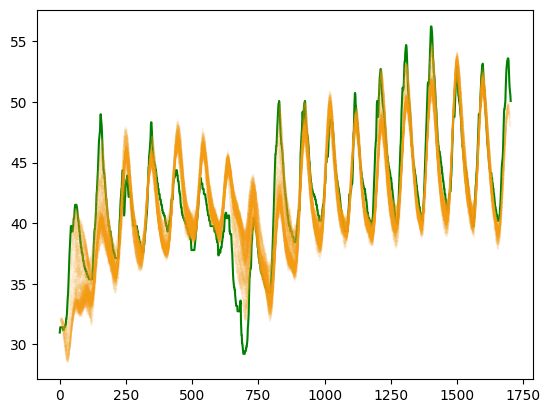

In [208]:
test_data = DataLoader(TimeSeriesDataset(val_df,future_steps= future_steps, target_column = ['OT'],p_lag=p_lag), batch_size=batch_size,drop_last=True)
output_list = []
target_list = []

for i, data in enumerate(test_data):
    inputs, labels = data
    output = net(inputs)
    #print(f"predicted output is {output.squeeze(0,1).tolist()[0]} and true value is {labels.squeeze(1,2).tolist()[0]}")
    if i > 200: 
        break
    [output_list.append(out) for out in output.tolist()]
    [target_list.append(tar) for tar in labels.squeeze(1,2).tolist()]

target = []
for i in range(len(target_list)): 
    if i == 0: 
        target = target_list[i]
    else: 
        target.append(target_list[i][len(target_list[i])-1])

fig = plt.figure(figsize=(15, 15))
plt.plot(range(0, len(target)), target, 'g')
for i, output in enumerate(output_list, start=0): 
    plt.plot(range(i, i +future_steps), output, color='#F39C12',linewidth=1, linestyle='-.',alpha=0.1)


In [28]:
#prediction for 100 steps in the case of only univariate time series
steps = 100
for i, data in enumerate(test_data): 
    input, _ = data
    prediction = net(input)
    new_input = torch.cat([input.squeeze(0).squeeze(0)[1:], prediction.squeeze(0)])
    for _ in range(steps): 
        prediction = net(new_input)
        new_input = torch.cat([new_input.squeeze(0).squeeze(0)[1:], prediction.squeeze(0)])   
    new_input

KeyboardInterrupt: 

In [45]:
#iterative prediction for 100 steps in the case of only multivariate time series
# we assume full knowledge of covariates at each time 
steps = 1000
prediction_list = []
target_list = []
for i, data in enumerate(test_data): 
    input, target = data
    prediction = net(input)
    prediction_list.append(prediction.squeeze(0).item())
    target_list.append(target.squeeze(0).item())
    if i == (steps -1): 
        break
    new_input

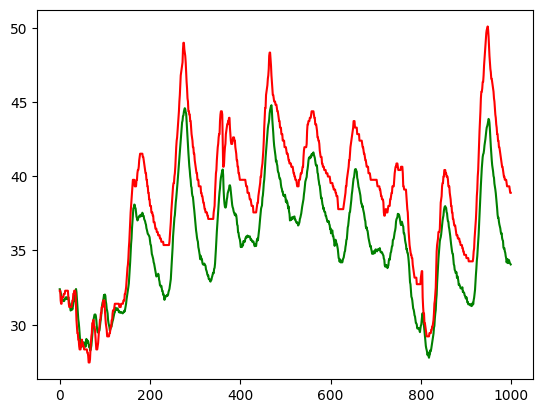

In [46]:
import matplotlib.pyplot as plt
plt.plot(prediction_list, 'g', target_list, 'r')
plt.show()